## 数据标准化

* 在细胞RNA测序数据中经常观察到文库之间测序覆盖率的系统性差异
    * 通常源于cDNA捕获或细胞间PCR扩增效率的技术差异
* 标准化旨在消除这些差异，使它们不会干扰`细胞表达谱`的比较
* 确保在细胞群中观察到的任何异质性或差异表达都是有生物学而非技术偏差驱动的

### 标准化

In [3]:
import scanpy as sc

# ==========================
# PBMC3K数据
# ==========================
adata = sc.datasets.pbmc3k()

# 省略了质量控制的步骤

# ==========================
# 数据标准化
# ==========================
# 总计数归一化
sc.pp.normalize_total(adata, target_sum=1e4)
# 对数化
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


#### normalize_total函数：
* 将最大值压缩到target_sum之内
* 每一行做归一化处理

In [5]:
from anndata import AnnData
import scanpy as sc
import numpy as np

sc.settings.verbosity = 2
np.set_printoptions(precision=2)
tmp_adata = AnnData(np.array([
   [3, 3, 3, 6, 6],
   [1, 1, 1, 2, 2],
   [1, 22, 1, 2, 2],
]))

print(tmp_adata.X)


X_norm = sc.pp.normalize_total(tmp_adata, target_sum=1, inplace=False)['X']
print("X_norm:\n", X_norm)



[[ 3  3  3  6  6]
 [ 1  1  1  2  2]
 [ 1 22  1  2  2]]
normalizing counts per cell
    finished (0:00:00)
[[0.14 0.14 0.14 0.29 0.29]
 [0.14 0.14 0.14 0.29 0.29]
 [0.04 0.79 0.04 0.07 0.07]]


#### 对数化
* 对偏度比较大的数据用log1p函数进行转化，使其更加服从高斯分布
* 其中，log1p = log(1 + x)

#### 其他
除了简单的normalize_total，还有：
* Batch Normalization
* Layer Normalization
* Group Normalization

## 特征选择

* 探索性分析中使用scRNA-seq数据表征细胞间的异质性。
* 聚类和降维等任务根据细胞的`基因表达谱`比较细胞，设计将每个基因的差异聚合成细胞之间的相似性度量
* 希望选择包含有`系统生物学`的有用信息的基因，同时删除包含随机噪声的基因
* 目的是保留有趣的生物结构，而不会出现模糊该结构的差异，并减少数据的大小提高效率

extracting highly variable genes
    finished (0:00:00)


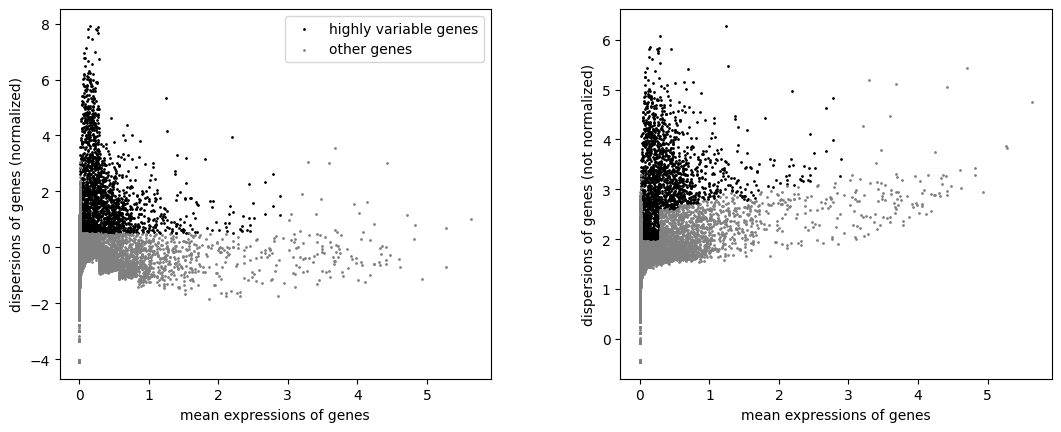

In [7]:
# ==========================
# 特征选取
# ==========================
# 识别高度可变的基因
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata, save='_pbmc3k.png')

#### 高可变基因如何计算

* 计算均值和方差
```
mean, var = materialize_as_ndarray(_get_mean_var(X))
```

* 计算`离散度`——数据偏离平均值的程度
```
dispersion = var / mean
```

* 离散度归一化
```
dispersions_norm = (dispersions - disp_mean_bin) / disp_std_bin
```

* 取基因集
    * dispersions_norm排序，按n_top_genes取或者按dispersions_norm做条件过滤
```
	(
	mean > min_mean,
	mean < max_mean,
	dispersion_norm > min_disp,
	dispersion_norm < max_disp,
	)
```

* 为了提高计算速度，高可变基因(hvg)，一般取值2000左右

## 降维

减少数据中单独维度的数量，减少downstrem下游分析(如聚类)中的计算工作

### PCA

computing PCA
    with n_comps=50
    finished (0:00:00)


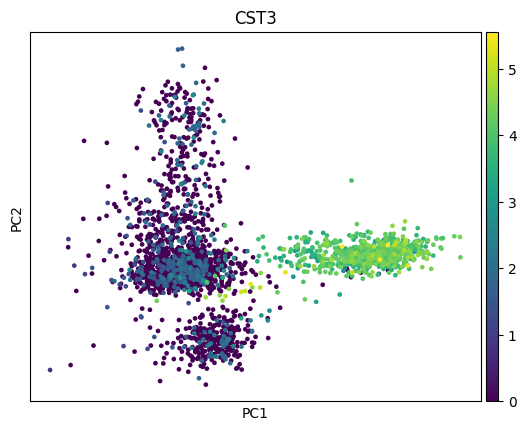

In [8]:
# 经过质量控制、数据标准化、特征提取后的数据集
results_file = './data/pbmc3k_processed.h5ad'

# h5py的版本要大于>3.3.0
# pip install h5py==3.5.0 -i https://pypi.tuna.tsinghua.edu.cn/simple
adata = sc.read(results_file)

# ==========================
# 降维和可视化
# ==========================
#通过运行主成分分析(PCA)来降低数据的维数。
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='CST3', save='_pbmc3k_CST3.png')

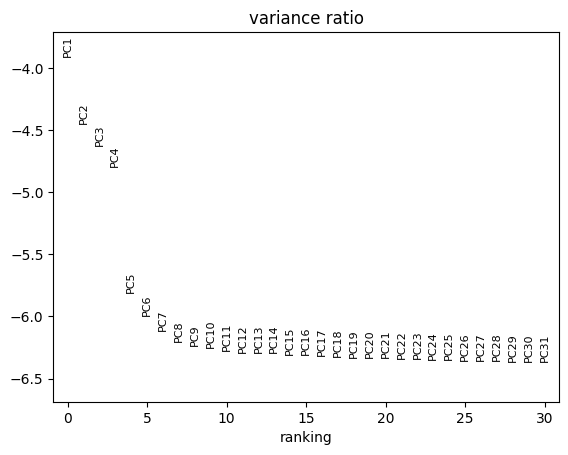

In [9]:
# 显示每个成分
sc.pl.pca_variance_ratio(adata, log=True, save='_pbmc3k_pc.png')

#### SVD原理

`奇异值分解SVD`是一种适用于任何矩阵的一种分解方法，对于任意矩阵A总是存在一个SVD：
$$
A = U \Sigma V^T
$$
其中
* 假设A是一个m*n的矩阵，那么U是m*m，V是n*n，$\Sigma$是m*n的矩阵，除了对角线其他元素都为0,对角线上元素为奇异值
* 分解步骤
    * $AA^T$的特征值和特征向量，用单位化的特征向量构成U
    * $A^TA$的特征值和特征向量，用单位化的特征向量构成V
    * 将$AA^T$或$A^TA$的特征值求平方根，然后构成$\Sigma$

#### PCA原理
基于SVD分解协方差矩阵实现PCA算法输入，数据集$X = \{ x_1, x_2, ..., x_n \}$需要降到k维
1. 去平均值，每一维特征减去各自的均值
2. 计算协方差矩阵
3. 通过SVD计算协方差矩阵的特征值和特征向量
4. 对特征值从大到小排序，选择其中最大的k个，将其对应的k个特征向量分别作为列向量组成`特征向量矩阵`
5. 将数据转换到k个特征向量构建的新空间中

### t-SNE
Hinton提出的
建立高维数据向地维数据的映射——随机邻域嵌入(SNE stochastic neighbor embedding)
* 首先将数据点之间的高维`欧式距离`转换为表示相似性的`条件概率`
    * 其中$\sigma_i$是以$x_i$为中心的`高斯方差`
$$
p_{j|i} = \frac{exp(-||x_i - x_j||^2 / 2\sigma^2_i)}{\Sigma_{i \not= k} exp(-||x_i - x_k||^2 / 2 \sigma^2_i) }
$$

* 对与高维数据点$x_i$和$x_j$的地维对应物$y_i$和$y_j$，可以计算类似的条件概率
$$
q_{j|i} = \frac{exp(-||y_i - y_j||^2)}{\Sigma_{i \not= k} exp(-||y_i - y_k||^2) }
$$

* 如果映射点可以比较好的模拟高维数据点之间的相似性，则两个条件概率将相似，SNE旨在找到一种低维表示以最大限度减少p, q之间的不匹配
* p和q建模的自然度量是KL散度(Kullback Leibler divergence)，SNE使用梯度下降最小化多有数据点上的KL散度的综合，给定成本(cost):
$$
C = \Sigma_a KL(P_i || Q_i) = \Sigma_i \Sigma_j p_{j|i} log \frac{p_{j|i}}{q_{j|i}}
$$
* 使用梯度下降
$$
\frac{\partial C}{\partial y_i} = 2 \Sigma_j (p_{j|i} - q_{j|i} + p_{i|j} - q_{i|j})(y_i - y_j)
$$
* 其中$\sigma_i$是通过困惑度来找出，计算时间较长：
$$
Perp(P_i) = 2^{H(P_i)}
$$
其中$H(P_i)$是比特为单位测量的$P_i$的`香农熵`

计算距离


distances = pairwise_distances(X, metric=self.metric, squared=True)


计算条件概率


Compute conditional probabilities such that they approximately match the desired perplexity

distances = distances.astype(np.float32, copy=False)

耗时的步骤
conditional_P = _utils._binary_search_perplexity(
	distances, desired_perplexity, verbose
)

P = conditional_P + conditional_P.T

sum_P = np.maximum(np.sum(P), MACHINE_EPSILON)

P = np.maximum(squareform(P) / sum_P, MACHINE_EPSILON)
    

计算降维后的embedding

params, kl_divergence, it = _gradient_descent(obj_func, params, **opt_args)

X_embedded = params.reshape(n_samples, self.n_components)

### UMAP

/home/shenc/anaconda3/envs/rna_seq/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-09-26 14:21:01.637219: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-26 14:21:01.639163: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-26 14:21:01.644570: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-26 14:21:01.653175: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-26 14:

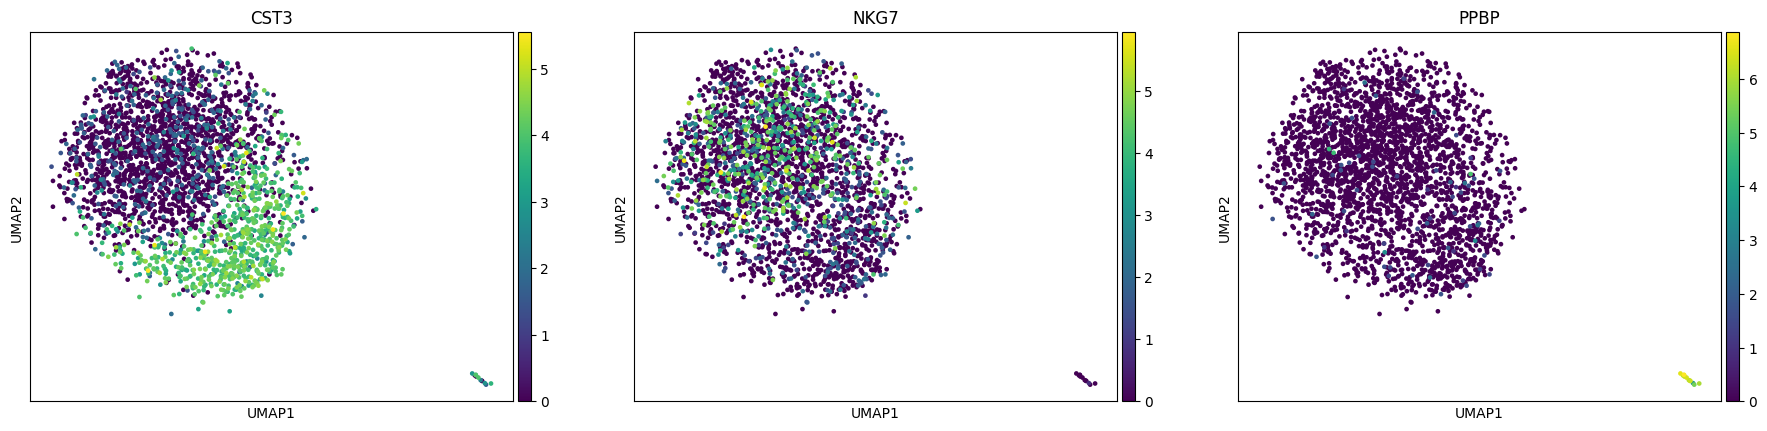

In [1]:
import scanpy as sc

# 经过质量控制、数据标准化、特征提取后的数据集
results_file = './data/pbmc3k_processed.h5ad'

# h5py的版本要大于>3.3.0
# pip install h5py==3.5.0 -i https://pypi.tuna.tsinghua.edu.cn/simple
adata = sc.read(results_file)

# ==========================
# 降维和可视化
# ==========================
#通过运行umap来降低数据的维数。
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], save='_pbmc3k_CST3_NKG7_PPBP.png')

#### UMAP原理
Leland Mclnnes(2018)

也是建立一个从高维数据向低维数据的映射

##### Algrothm 1
几个步骤
* Local Fuzzy Simplical Set 计算局部模糊单纯集
* Spectral Embedding 谱嵌入优化
* Optimize Embedding 嵌入优化

##### Algrothm 2
构造模糊单纯形集
* Approx Nearest Neighbors 计算x的k个`最邻近`
* Smooth KNN Dict 进行平滑的k紧邻距离
* 更新k紧邻距离
##### Algrothm 3

https://zhuanlan.zhihu.com/p/538427540

## 聚类
聚类是一种无监督学习过程，用于凭经验定义具有相似表达谱的`细胞组`，主要目的是将复杂的scRNA-seq数据汇总为可消化的格式供人类解释

### Louvain

/home/shenc/anaconda3/envs/rna_seq/lib/python3.11/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 1838 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


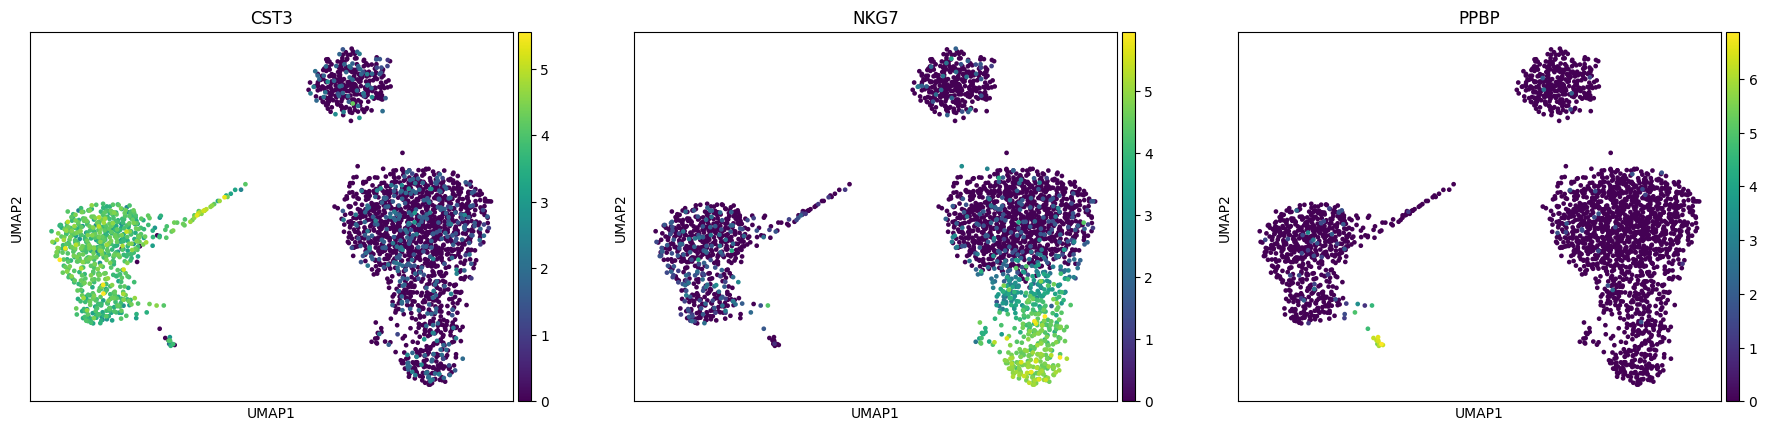

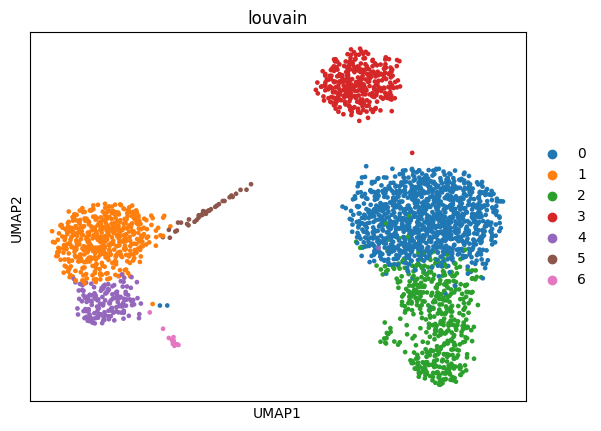

In [3]:
import scanpy as sc

# 经过质量控制、数据标准化、特征提取后的数据集
results_file = './data/pbmc3k_processed.h5ad'

# h5py的版本要大于>3.3.0
# pip install h5py==3.5.0 -i https://pypi.tuna.tsinghua.edu.cn/simple
adata = sc.read(results_file)

# ==========================
# 降维、聚类和可视化
# ==========================
#通过运行umap来降低数据的维数。
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], save='_pbmc3k_CST3_NKG7_PPBP.png')

# pip install scanpy[louvain]==1.8.2
sc.tl.louvain(adata)
sc.pl.umap(adata, color=['louvain'], save='_pbmc3k_louvain.png')

louvain是一种基于多层次(逐论启发式迭代)优化模块度的算法

#### 模块度
模块度是评估一个社区网络划分好坏的度量方法，其物理含义是社区内节点的连边数和随机情况下的变数之差，其组织范围是[-1/2, 1)

可以理解为社区内部边的权重减去所有与社区节点相连的边的权重和

如果是无向图，就是社区内部边度数减去社区内节点的总度数
$$
Q = \frac{1}{2m} \Sigma_{i, j} [ A_{ij} - \frac{k_i k_j}{2m}] \sigma(c_i, c_j)
$$
* A是邻接矩阵，表示两节点之间的权重
* $k_i = \Sigma_j A_{ij}$是和节点i相连的边的权重值和
* $m = \frac{1}{2} \Sigma_{ij}A_{ij}$是所有边的权重值和
* $\sigma$示性函数表示两个点在不在同一个社区

#### 模块度增量
模块增益度是评价一次迭代效果好坏的数值化指标，是一种启发式的优化过程
$$
\Delta Q = [ \frac{\Sigma_{in} + k_{i, in}}{2m} - (\frac{\Sigma_{tot} + k_i}{2m})^2 ] - [ \frac{\Sigma_{in}}{2m} - (\frac{\Sigma_{tot}}{2m})^2 - \frac{k_i}{2m} ]\\
= \frac{1}{2m} (k_{i, in} - \frac{\Sigma_{tot} k_i}{m})
$$
* $k_{i, in}$是节点i入集群C的权重之和
* $\Sigma_{tot}$ 是入集群C的权重
* $k_i$是入节点i的总权重
#### 算法步骤
* 初始化：将途中每个节点看成一个独立的社区，社区的数目与节点个数相同
* first phase迭代——社区间节点转移：依次尝试把节点i分配到每个邻居节点所在的社区，计算分配前后的模块度变化$\Delta Q$
* 重复上述操作，直到所有节点的所属社区不再变化，即社区间的节点转移结束，可以理解为本论迭代的Local Maximization已达到
* second phase——Rebuilding Graph：对整个图进行一个rebuild，对图进行重构，将所有在同一个社区的节点重构成一个新社区，社区内节点之间的边的权重更新为新节点的环的权重，社区间的边权重更新为新节点间的边权重
* 重复first phase和second phase，直到整个图的模块度不再发生变化

### Leiden

/home/shenc/anaconda3/envs/rna_seq/lib/python3.11/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 1838 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


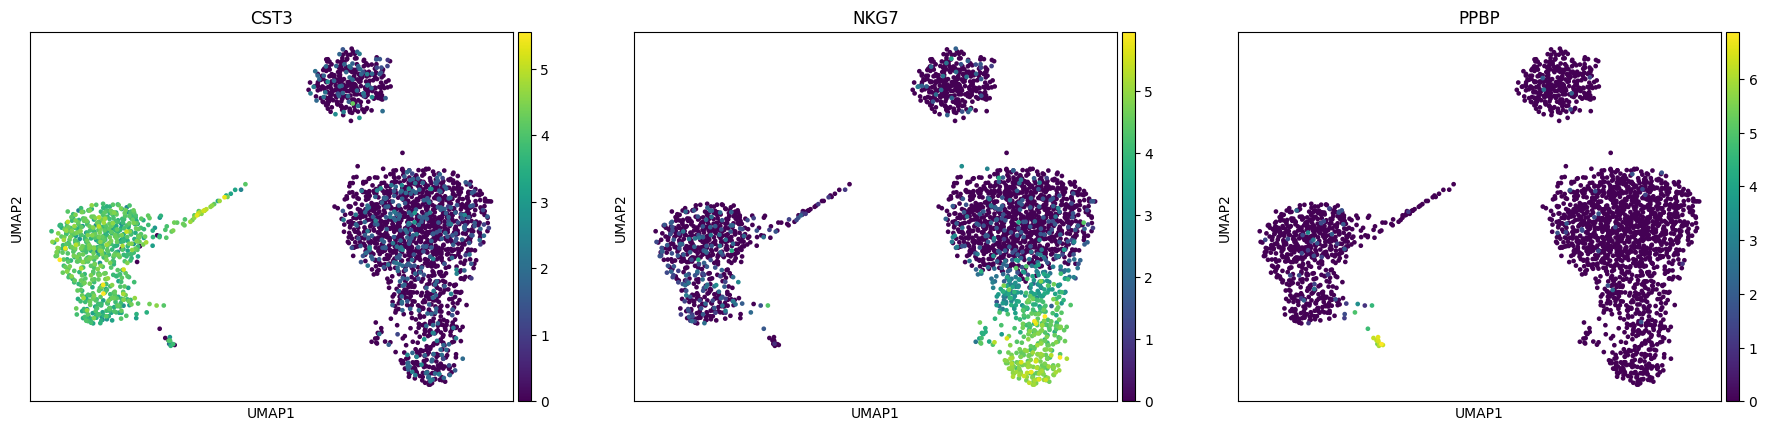

/tmp/ipykernel_5124/3727619484.py:18: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


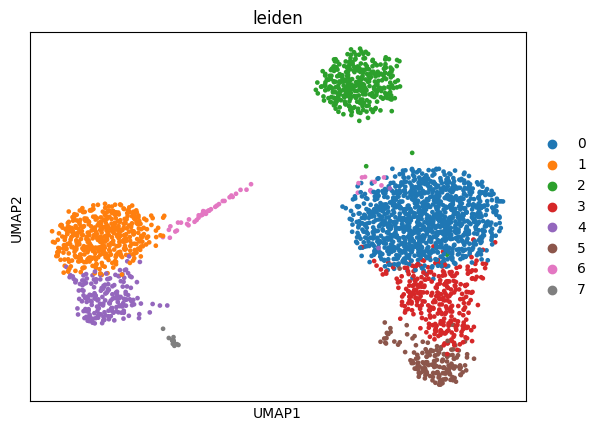

In [5]:
import scanpy as sc

# 经过质量控制、数据标准化、特征提取后的数据集
results_file = './data/pbmc3k_processed.h5ad'

# h5py的版本要大于>3.3.0
# pip install h5py==3.5.0 -i https://pypi.tuna.tsinghua.edu.cn/simple
adata = sc.read(results_file)

# ==========================
# 降维和可视化
# ==========================
#通过运行umap来降低数据的维数。
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], save='_pbmc3k_CST3_NKG7_PPBP.png')

sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden'], save='_pbmc3k_leiden.png')

#### louvain存在的几个小问题
* 社区划分的精度有举行爱女性
* 分组内细胞分布密度的大小会影响亚群的鉴定
* 被鉴定为同一个分群的细胞群内，存在两个没有连线的小分群

#### leiden是为了解决这些问题
##### 模块度的定义不同
$$
H = \frac{1}{2m} \Sigma_c [e_c - \gamma \frac{K_c^2}{2m} ]
$$
* m总边数
* $e_c$社区c内的边数$k_c$和社区c节点的度数值之和
* $\gamma > 0$分辨率参数，更高的导致更多的社区

Leiden使用质量函数Constant Potts Model(CPM)，克服模块度的一些缺点(分辨率限制)
$$
H = \Sigma_c [e_c - \gamma C_{n_c}^2]
$$
* n代表节点的数目
* $\gamma$作用类似于一种阈值：社区的密度至少为$\gamma$，而社区之间的密度应低于$\gamma$
* 分辨率越高，社区越多

Leiden 算法从单例分区 ( a ) 开始。该算法将单个节点从一个社区移动到另一个社区以找到一个分区 ( b )，然后对其进行细化 ( c )。聚合网络 ( d ) 基于细化分区创建，使用非细化分区为聚合网络创建初始分区。例如，（b）中的红色社区被细化为（c）中的两个子社区，聚合后成为（d）中的两个独立节点，都属于同一个社区。然后，该算法移动聚合网络中的各个节点（e）。在这种情况下，细化不会更改分区 ( f )。重复这些步骤，直到无法做出进一步的改进[6]。

https://zhuanlan.zhihu.com/p/538605686

## 发现Marker基因

聚类之后，查找每个类别代表性的基因

/home/shenc/anaconda3/envs/rna_seq/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/shenc/anaconda3/envs/rna_seq/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:668: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/shenc/anaconda3/envs/rna_seq/lib/python3.11/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 1838 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


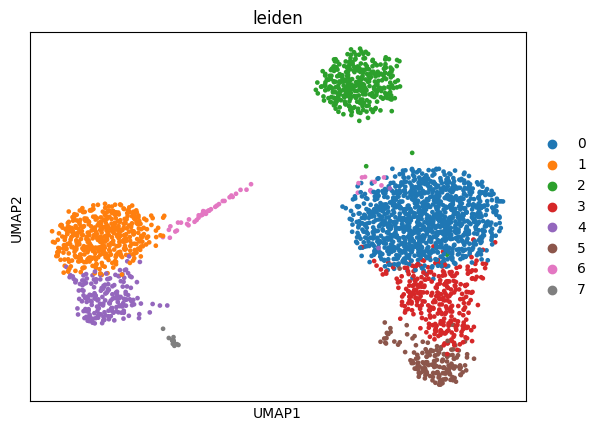

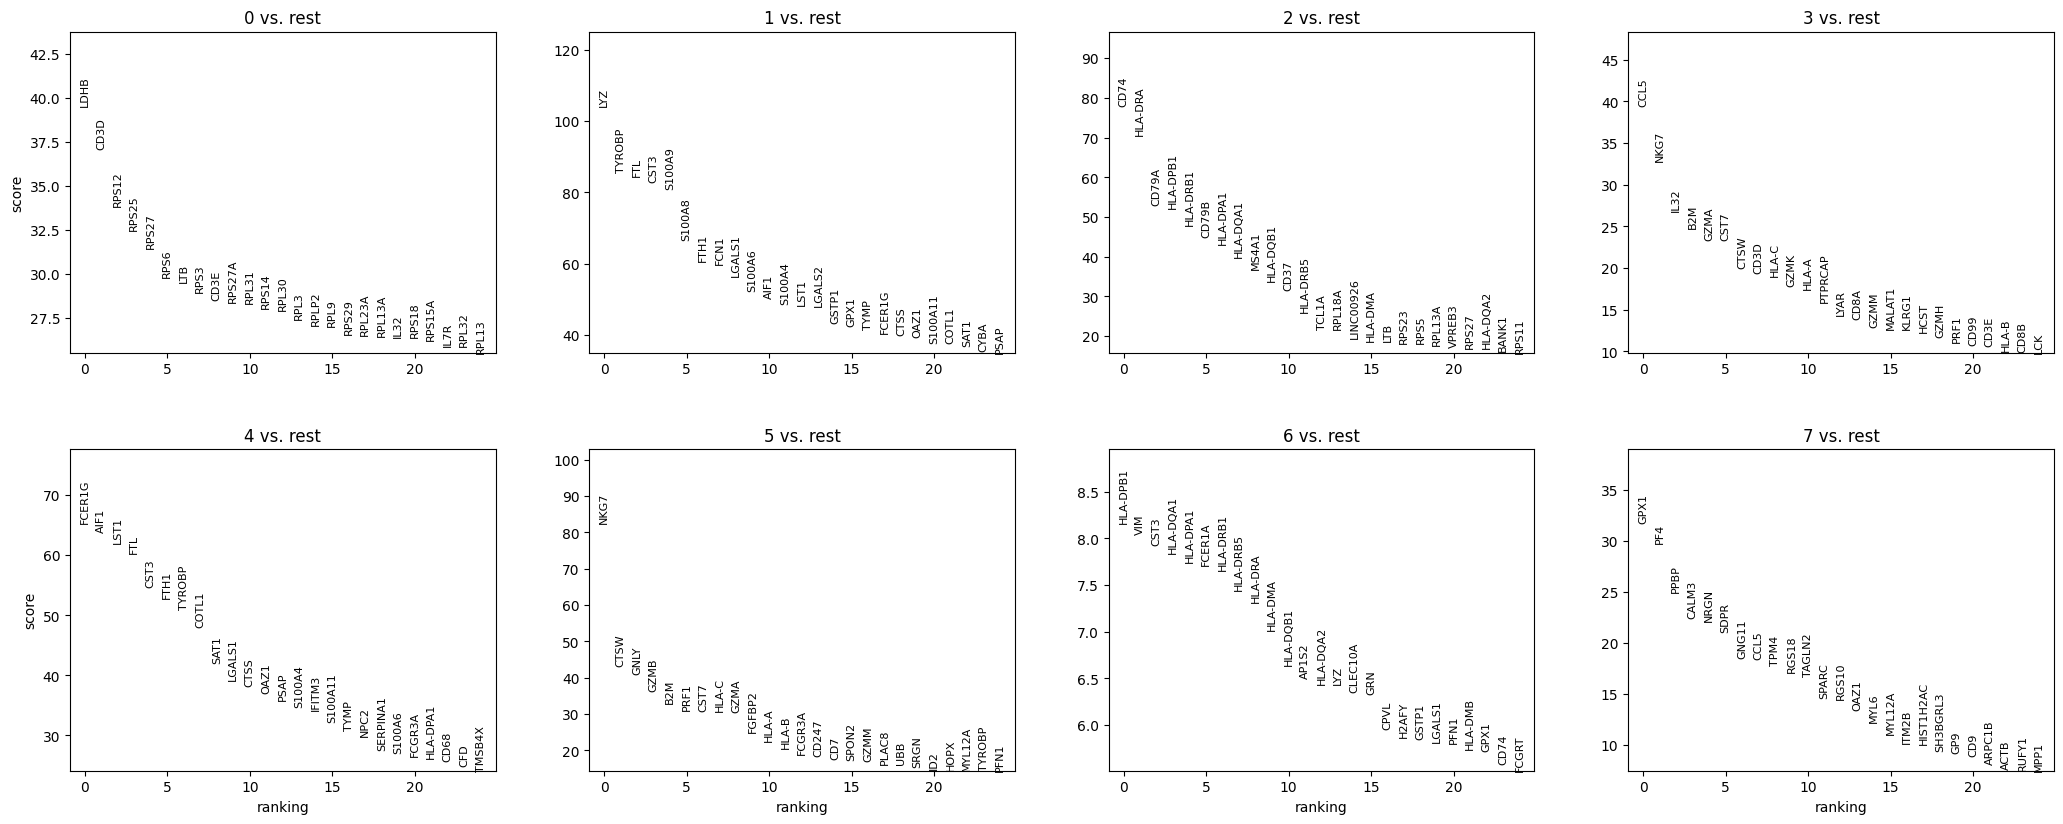

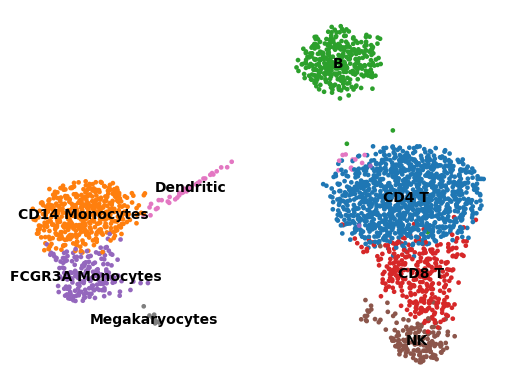

In [6]:
import scanpy as sc

# ==========================
# PBMC3K数据
# ==========================
adata = sc.datasets.pbmc3k()

# ==========================
# 质量控制
# ==========================
# 基本过滤
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# 计算质量控制指标
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# 根据基因数量和线粒体百分比进行过滤
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

# ==========================
# 数据标准化
# ==========================
#总计数归一化
sc.pp.normalize_total(adata, target_sum=1e4)
# 对数化
sc.pp.log1p(adata)


# ==========================
# 特征选取
# ==========================
# 识别高度可变的基因
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# 保存原始数据
adata.raw = adata
# 过滤
adata = adata[:, adata.var.highly_variable]

# 将数据缩放到单位方差
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)


# ==========================
# 降维、聚类、可视化
# ==========================
#通过运行umap来降低数据的维数。
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.umap(adata)

sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden'], save='_pbmc3k_leiden.png')

# ==========================
# 发现标志基因
# ==========================
# 根据聚类结果，找出代表该类的标志基因
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

# 细胞类型标注
new_cluster_names = [
    'CD4 T',
    'CD14 Monocytes',
    'B',
    'CD8 T',
    'FCGR3A Monocytes',
    'NK',
    'Dendritic',
    'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)
sc.pl.umap(
    adata, 
    color='leiden', 
    legend_loc='on data', 
    title='', 
    frameon=False, 
    save='_pbmc3k_annotation.png')

#### 步骤
1. 进行无监督据聚类，如leiden
2. 根据聚类结果，查找聚类间差异最大的基因作为候选Marker基因
3. 根据已知的细胞类型Marker基因和候选Marker基因，给聚类分配细胞名称

至此，一个基础的单细胞数据分析流程结束